In [1]:
import torch 
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import time
import matplotlib.pyplot as plt

In [2]:
class GCN(torch.nn.Module):
    """
    A two-layer Graph Convolutional Network (GCN) for semi-supervised node classification, replicating the architecture and regularization from the GCN paper.)
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # GCNConv Layer 1 (Input Features --> Hidden Features)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        
        # GCNConv Layer 2 (Hidden Features --> Output Classes)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        # Layer 1: Propagation, ReLU Activation, and Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = F.dropout(x, p = 0.5, training = self.training)
        
        # Layer 2: Propagation to final class
        x = self.conv2(x, edge_index)
        
        # Output: Log-Softmax for stable log-probabilities
        return F.log_softmax(x, dim = 1)

In [3]:
dataset = Planetoid(root = "./data/Cora", name = "Cora")
data = dataset[0]

In [4]:
# Hyperparameters
HIDDEN_UNITS = 16
LEARNING_RATE = 0.01
WEIGHT_DECAY = 1e-3
EPOCHS = 200

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

In [6]:
model = GCN(
    in_channels = dataset.num_features,
    hidden_channels = HIDDEN_UNITS,
    out_channels = dataset.num_classes
).to(device)

In [7]:
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

# Negative Log-Likelihood Loss used with log_softmax output
loss_fn = F.nll_loss

In [8]:
def train(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    # Calculate loss ONLY on the labeled training nodes
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    return loss.item()

@ torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    
    # Calculate Validation loss for early stopping logic
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
    
    masks = {"train": data.train_mask, "val": data.val_mask, "test": data.test_mask}
    accuracies = {}
    
    
    for name, mask in masks.items():
        pred = out[mask].argmax(dim = 1)
        correct = pred.eq(data.y[mask]).sum()
        accuracies[name] = int(correct) / int(mask.sum())
        
    return accuracies["train"], accuracies["val"], accuracies["test"], val_loss

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

best_val_loss = float("inf")
test_acc_at_best_val = 0
epochs_no_improve = 0
EARLY_STOPPING_WINDOW = 200

In [10]:
start_time = time.time()
print(f"Starting GCN training on Cora (Device: {device})...")

for epoch in range(1, EPOCHS + 1):
    loss = train(model, data, optimizer, loss_fn)
    train_acc, val_acc, test_acc, val_loss = test(model, data)
    
    # Store Metrics
    train_losses.append(loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        test_acc_at_best_val = test_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    if epochs_no_improve == EARLY_STOPPING_WINDOW:
        print(f"\nEarly Stopping at epoch {epoch} (best validation loss: {best_val_loss:.4f}).")
        break
    
end_time = time.time()

print("-" * 50)
print(f"Training finished in {end_time - start_time:.2f} seconds.")
print(f"Final Test Accuracy (at best validation point): {test_acc_at_best_val:.4f}")

Starting GCN training on Cora (Device: cuda)...
Epoch: 001, Loss: 1.9366, Val Loss: 1.9058, Train Acc: 0.5571, Val Acc: 0.2480, Test Acc: 0.2690
Epoch: 005, Loss: 1.4098, Val Loss: 1.5911, Train Acc: 0.9143, Val Acc: 0.6300, Test Acc: 0.6280
Epoch: 010, Loss: 0.7658, Val Loss: 1.1774, Train Acc: 0.9786, Val Acc: 0.7520, Test Acc: 0.7470
Epoch: 015, Loss: 0.4302, Val Loss: 0.9274, Train Acc: 0.9857, Val Acc: 0.7620, Test Acc: 0.7810
Epoch: 020, Loss: 0.2417, Val Loss: 0.8315, Train Acc: 0.9929, Val Acc: 0.7580, Test Acc: 0.7810
Epoch: 025, Loss: 0.1514, Val Loss: 0.7934, Train Acc: 1.0000, Val Acc: 0.7540, Test Acc: 0.7810
Epoch: 030, Loss: 0.1195, Val Loss: 0.7752, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7870
Epoch: 035, Loss: 0.0724, Val Loss: 0.7585, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.7880
Epoch: 040, Loss: 0.0934, Val Loss: 0.7704, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7910
Epoch: 045, Loss: 0.0755, Val Loss: 0.8171, Train Acc: 1.0000, Val Acc: 0.7620,

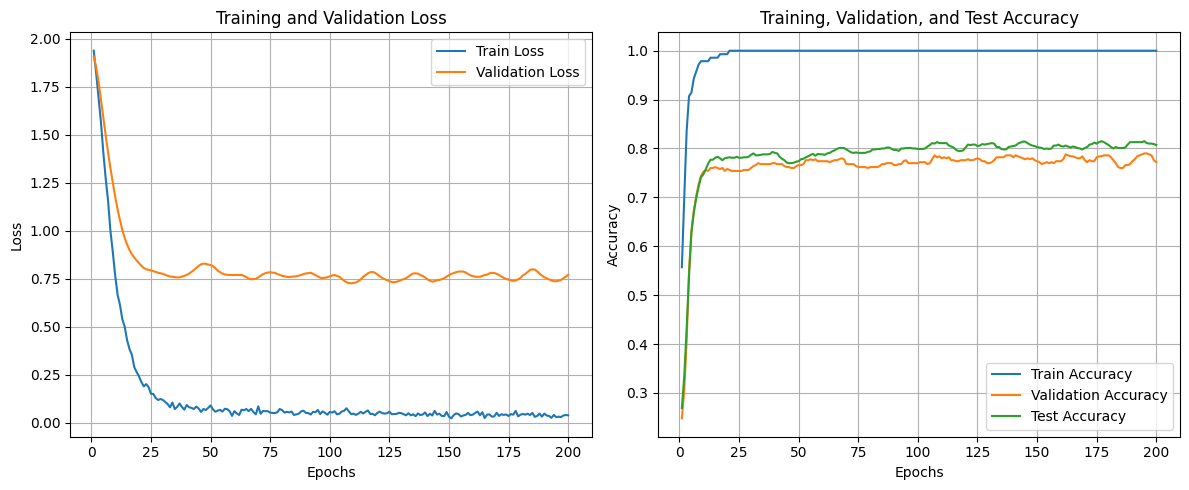

In [11]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()